# Pancreatic cancer - Eduati 2020

Model from the paper: doi: 10.15252/msb.209690 (link: https://www.ncbi.nlm.nih.gov/pubmed/32073727)

## Training data
Drug response data was obtained from GitHub repository: https://github.com/saezlab/ModelingMPS/tree/master/data/MIDAS_files

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from BNMPy import booleanNetwork as bn  
from BNMPy import BMatrix  
from pathlib import Path

In [3]:
data_aspc1 = pd.read_csv('../data/Eduati2020_AsPC1.csv')
data_aspc1

,TR:AsPC1:CellLine,TR:EGFRi,TR:JAKi,TR:AktPi,TR:PDPK1i,TR:MEKi,TR:AktMi,TR:IKKsi,TR:PI3Ki,TR:TNF,TR:EGF,DA:ALL,DV:Cas3
0,1,0,0,0,0,0,0,0,0,0,1,0,0.000000
1,1,1,0,0,0,0,0,0,0,0,1,0,0.000000
2,1,0,1,0,0,0,0,0,0,0,1,0,0.000000
3,1,1,1,0,0,0,0,0,0,0,1,0,0.000000
4,1,0,0,1,1,0,0,0,0,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,0,0,1,1,0,0,0,0,1,1,30,0.317508
70,1,0,0,0,0,1,0,0,0,1,1,30,0.431260
71,1,0,0,0,0,0,1,0,0,1,1,30,0.579572
72,1,0,0,0,0,0,0,1,0,1,1,30,0.532916


In [29]:
def row_to_condition(row, inhib_cols, stim_cols):
    """Return e.g.  'EGF, EGFRi'  or  'Untreated'."""
    inhibitors = [c.split(':')[-1][:-1]      
                  for c in inhib_cols if row[c] == 1]

    stimuli    = [c.split(':')[-1]    
                  for c in stim_cols if row[c] == 1]

    label = ",".join(stimuli + inhibitors)
    return label if label else "Untreated"

files = {
    "AsPC1": "../data/Eduati2020_AsPC1.csv",
    "BxPC3": "../data/Eduati2020_BxPC3.csv",
}

tidy = []
for cell, f in files.items():
    df = pd.read_csv(f,index_col=0)

    inhib_cols = [c for c in df if c.startswith('TR:') and c.endswith('i')]
    stim_cols  = [c for c in df if c.startswith('TR:') and not c.endswith('i')]

    df['condition'] = df.apply(row_to_condition,
                               axis=1,
                               inhib_cols=inhib_cols,
                               stim_cols=stim_cols)

    cas3 = (df.groupby('condition', sort=False)['DV:Cas3']
              .mean()
              .reset_index())
    cas3['cell_line'] = cell
    tidy.append(cas3)

tidy_df = (pd.concat(tidy)
           .pivot(index='cell_line', columns='condition', values='DV:Cas3'))

tidy_df

condition,EGF,"EGF,AktM","EGF,AktM,IKKs","EGF,AktM,PI3K","EGF,AktP,PDPK1","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,IKKs","EGF,AktP,PDPK1,MEK","EGF,AktP,PDPK1,PI3K","EGF,EGFR",...,"EGF,MEK,PI3K","EGF,PI3K","TNF,EGF","TNF,EGF,AktM","TNF,EGF,AktP,PDPK1","TNF,EGF,EGFR","TNF,EGF,IKKs","TNF,EGF,JAK","TNF,EGF,MEK","TNF,EGF,PI3K"
cell_line,,,,,,,,,,,,,,,,,,,,,
AsPC1,0.0,0.185301,0.305526,0.280940,0.079827,0.223278,0.084080,0.091051,0.128164,0.158850,...,0.258055,0.184611,0.123828,0.289786,0.158754,0.240606,0.266458,0.267496,0.215630,0.290386
BxPC3,0.0,0.133082,0.239388,0.228764,0.211012,0.500000,0.371753,0.402430,0.348821,0.174711,...,0.180111,0.126332,0.092019,0.201902,0.312164,0.181264,0.135495,0.166590,0.146508,0.206557


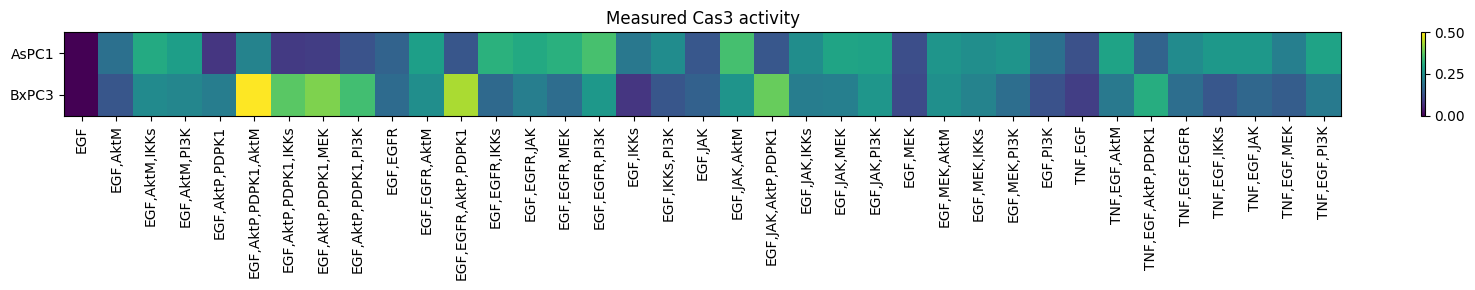

In [30]:
fig, ax = plt.subplots(figsize=(0.4*tidy_df.shape[1]+2, 3))
im = ax.imshow(tidy_df, aspect="auto")
ax.set_xticks(range(tidy_df.shape[1])); ax.set_xticklabels(tidy_df.columns, rotation=90)
ax.set_yticks(range(tidy_df.shape[0])); ax.set_yticklabels(tidy_df.index)
ax.set_title("Measured Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Simulate the original model

Consider the mutations in the cell line.  
Mutation profiles for the cell lines are obtained from the GDSC database.

In [45]:
file = '../input_files/Eduati2020.txt'
network = BMatrix.load_network_from_file(file)

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)
connectivity_matrix = BMatrix.get_connectivity_matrix(equations, upstream_genes, gene_dict)
truth_table = BMatrix.get_truth_table(equations, upstream_genes)
ngenes = len(equations)

# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {'AsPC1': 'RAS,p53',
                 'BxPC3': 'p53',
                 'Normal': ''}

# Dic file to specify how should the values of the genes be changed when mutated
file_mutations = '../input_files/mutations_Eduati2020.txt'
mutations_dict = BMatrix.get_mutation_dict(file_mutations)
print(f'mutations_dict: {mutations_dict}')

file_perturbations = '../input_files/perturbed_genes_Eduati2020.txt'
perturbations_dict = BMatrix.get_mutation_dict(file_perturbations)
print(f'perturbations_dict: {perturbations_dict}')

No initial state provided, using a random initial state
mutations_dict: {'p53': 0, 'RAS': 1, 'JNKK': 0}
perturbations_dict: {'EGFR': 0, 'JAK': 0, 'Akt': 0, 'PDPK1': 0, 'MEK': 0, 'IKKs': 0, 'PI3K': 0, 'EGF': 1, 'TNF': 1, 'AktP': 0, 'AktM': 0}


In [48]:
## no noise
n = 1000
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update(n)
        # network_traj = network.update_noise(0.05, 600)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [49]:
sim_df

,EGF,"EGF,AktM","EGF,AktM,IKKs","EGF,AktM,PI3K","EGF,AktP,PDPK1","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,IKKs","EGF,AktP,PDPK1,MEK","EGF,AktP,PDPK1,PI3K","EGF,EGFR",...,"EGF,MEK,PI3K","EGF,PI3K","TNF,EGF","TNF,EGF,AktM","TNF,EGF,AktP,PDPK1","TNF,EGF,EGFR","TNF,EGF,IKKs","TNF,EGF,JAK","TNF,EGF,MEK","TNF,EGF,PI3K"
AsPC1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BxPC3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# with noise
n = 500000
noise = 0.05
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        # network_traj = network.update(n)
        network_traj = network.update_noise(noise, n)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [57]:
sim_df

,EGF,"EGF,AktM","EGF,AktM,IKKs","EGF,AktM,PI3K","EGF,AktP,PDPK1","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,IKKs","EGF,AktP,PDPK1,MEK","EGF,AktP,PDPK1,PI3K","EGF,EGFR",...,"EGF,MEK,PI3K","EGF,PI3K","TNF,EGF","TNF,EGF,AktM","TNF,EGF,AktP,PDPK1","TNF,EGF,EGFR","TNF,EGF,IKKs","TNF,EGF,JAK","TNF,EGF,MEK","TNF,EGF,PI3K"
AsPC1,0.734044,0.74278,0.749984,0.750028,0.748776,0.756952,0.753588,0.754732,0.754368,0.745828,...,0.746132,0.742736,0.744008,0.745812,0.751776,0.748928,0.751356,0.746924,0.750688,0.753176
BxPC3,0.729192,0.73772,0.743628,0.741112,0.741784,0.750792,0.747292,0.748256,0.750464,0.736884,...,0.739948,0.737592,0.738036,0.745228,0.744328,0.743560,0.741684,0.742624,0.739788,0.746332
Normal,0.727068,0.73614,0.742456,0.739256,0.739620,0.747280,0.749392,0.747408,0.747532,0.736132,...,0.739748,0.735800,0.736692,0.742712,0.747828,0.744388,0.736560,0.743840,0.746540,0.739752


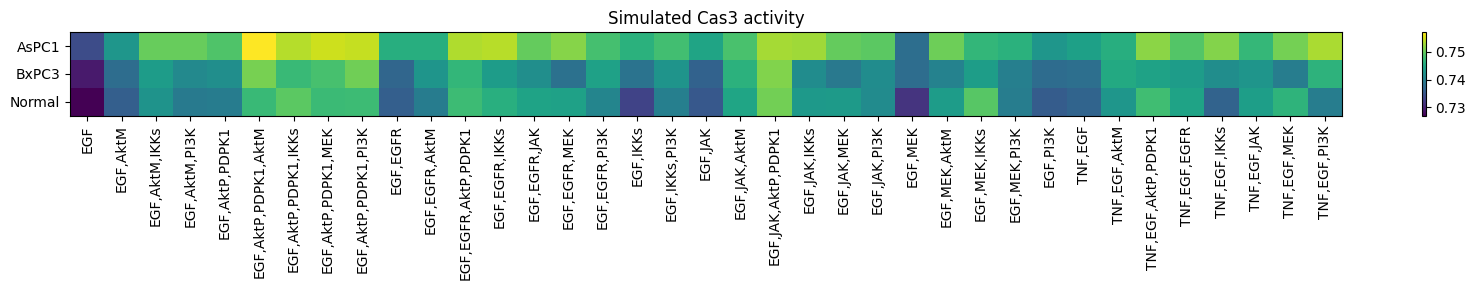

In [58]:
fig, ax = plt.subplots(figsize=(0.4*sim_df.shape[1]+2, 3))
im = ax.imshow(sim_df, aspect="auto")
ax.set_xticks(range(sim_df.shape[1])); ax.set_xticklabels(sim_df.columns, rotation=90)
ax.set_yticks(range(sim_df.shape[0])); ax.set_yticklabels(sim_df.index)
ax.set_title("Simulated Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()